# Kim's CNN for Fake News Classification

**Apurv Jain**

**2017KUCP1016**

In 2014, Yoon Kim's Paper, [Convolutional Neural Networks for Sentence Classification](https://www.aclweb.org/anthology/D14-1181/), showed that CNNs can be used for text classification as well, and can even outperform some of the existing models. Although, Kim has discussed four different models, in this notebook, I have implemented one of the Kim's model, namely, **CNN non-static** model, but with a few changes. 

As done for the original model, I have formed Word2Vec CBOW embeddings of 300D (300 dimensions) using **gensim**. Unknown words have been randomly initialized, and vectors can be fine-tuned while training the model. 

In the original model, he applied convolutions on these 2D representations, with different window sizes of 3,4 and 5 with 100 feature maps each; and then performed max pooling on each convolution layer, after concatenation of layers and flattening, followed by a dropout layer (drouput rate 0.5), before the final output layer. He used l2 contraint of 3 in the convolution layer and a mini-batch  size of 50. Also, he used the Adadelta optimizer with 10% of training data as testing set.

**How this implementation differs from the original non-static model**

I have used covolutions of sizes 2, 3, 4, 5 and 6 to increase the accuracy of the model. For this, I have generated Word2Vec embeddings with context size 6. Since the task for this assignment was to apply Kim's CNN for Fake News Classification, I have used the [Fake News Dataset](https://www.kaggle.com/c/fake-news/data?select=train.csv). Because of the constraint on processing power, I have used mini-batch size of 16 for training the model.

In [1]:
# importing required libraries
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras.models import Model
from keras.layers import *
from keras.utils.np_utils import to_categorical
import re

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from gensim.models import KeyedVectors

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# loading the dataset
# df = pd.read_csv('train.csv', index_col = 0)
df = pd.read_csv('../input/fake-news/train.csv', index_col = 0)
df.head()

,title,author,text,label
id,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
# checking for null values
df['title'].isnull().values.any()

True

In [4]:
# checking for null values
df['text'].isnull().values.any()

True

In [5]:
# concatinating the title and the text columns
df['news'] = df['title'].fillna('').str.cat(df['text'].fillna(''), sep = " ")
df.head()

,title,author,text,label,news
id,,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Why the Trut...
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


In [6]:
# extracting the required columns
df = df[['news', 'label']]
df.head()

,news,label
id,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",0
2,Why the Truth Might Get You Fired Why the Trut...,1
3,15 Civilians Killed In Single US Airstrike Hav...,1
4,Iranian woman jailed for fictional unpublished...,1


In [7]:
# some helper functions for pre-processing the text
def remove_urls(text):
    """For removing urls"""
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)

def remove_html(text):
    """For removing html text"""
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

def punct_remove(text):
    """For removing punctuations"""
    punct = re.sub(r"[^\w\s\d]","", text)
    return punct

def remove_stopwords(text):
    """For removing stopwords"""
    STOPWORDS = set(stopwords.words('english'))
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

In [8]:
# for cleaning or pre-processing the text
def clean_text(text):
    
    # remove urls
    new_text = remove_urls(text)
    
    # remove html text
    new_text = remove_html(new_text)
    
    # remove punctuations
    new_text = punct_remove(new_text)
    
    # lower casing the text
    new_text = new_text.strip().lower()
    
    # remove stop words
    new_text = remove_stopwords(new_text)
    
    return new_text

In [9]:
# clean news text
df['news'] = df['news'].apply(lambda x: clean_text(x))
df.head()

,news,label
id,,
0,house dem aide didnt even see comeys letter ja...,1
1,flynn hillary clinton big woman campus breitba...,0
2,truth might get fired truth might get fired oc...,1
3,15 civilians killed single us airstrike identi...,1
4,iranian woman jailed fictional unpublished sto...,1


In [10]:
# label counts
df.label.value_counts()

1    10413
0    10387
Name: label, dtype: int64

In [11]:
# maximun length of a sentence in the corpus
max_len = (df['news'].apply(lambda x: len(x.split(' ')))).max()
print('Max length of a sentence in the corpus: ' + str(max_len))

Max length of a sentence in the corpus: 20731


In [12]:
# tokenizing the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.news)
X = tokenizer.texts_to_sequences(df.news.values)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

# padding sequences with zeroes
X = pad_sequences(X, padding = 'post', maxlen = max_len)

# one hot encoding the labels
y = to_categorical(df.label)

In [13]:
# splitting the dataset for training and testing (keeping the test size 10% as suggested by Kim)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
print("Size of Training data: " + str(len(X_train)))
print("Size of Testing data: " + str(len(X_test)))

Size of Training data: 18720
Size of Testing data: 2080


The next cell includes code for generating the Word2Vec 300D CBOW embeddings. 
Since, the gensim version has been updated from 3.x to 4.x in 2021, there have been some changes introduced from the earlier version. Here, I have provided code for both the versions, as per the requirement, on whichever platform this code is run. (As of at the time of the implementation, Kaggle is using the latest version 4.x, while Google Colab is using verison 3.x)

In [14]:
# # importing required libraries
# from gensim.utils import simple_preprocess
# from gensim.models import Word2Vec

# # for generating word2vec embeddings
# tokenized_text = [simple_preprocess(text, deacc=True) for text in df.news]

# # CBOW model (sg = 0)
# # Embedding Dimensions
# size = 300
# # Context Window
# window = 6
# # Min count of words
# min_count = 1
# # CBOW
# sg = 0

# # for gensim 4.x
# w2v_model = Word2Vec(tokenized_text, vector_size = size, window = window, min_count = min_count, sg = sg)

# # for gensim 3.x
# w2v_model = Word2Vec(tokenized_text, size = size, window = window, min_count = min_count, sg = sg)

# word2vec_model_file = 'word2vec_cbow_' + str(window) + '_' + str(size) + '.model'
# w2v_model.save(word2vec_model_file)

In [15]:
# loading word2vec cbow embeddings

model_cbow = KeyedVectors.load('../input/word2vec-cbow-300model/word2vec_cbow_6_300.model')

In [16]:
# embedding index

embeddings_index = {}

# for gensim 4.x
for w in (model_cbow.wv.key_to_index).keys():
    embeddings_index[w] = model_cbow.wv[w]
    
# for gensim 3.x
# for w in model_cbow.wv.vocab.keys():
#     embeddings_index[w] = model_cbow.wv[w]

In [17]:
print('Number of word vectors: ' + str(len(embeddings_index)))
print('Number of unique tokens: ' + str(vocab_size))

Number of word vectors: 197135
Number of unique tokens: 213352


In [18]:
# 300 dimensions
embedding_dim = 300

# generating embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
    # for words not present, randomly initialize   
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

In [19]:
# model layers
def KimsCNN(embeddings, max_seq_length, num_words, embedding_dim, labels_index, trainable_weights = False):
    
    # input layer
    seq_input = Input(shape = (max_seq_length,), dtype = 'int32')
    
    # embedding layer
    embedding_layer = Embedding(num_words, embedding_dim, weights = [embeddings], input_length = max_seq_length,
                                trainable = trainable_weights)(seq_input)
    
    # reshape
    reshape = Reshape((max_seq_length, embedding_dim, 1))(embedding_layer)
    
    convs = []
    filter_sizes = [2, 3, 4, 5, 6]
    
    for filter_size in filter_sizes:
        
        # convolution layer
        l_conv = Conv2D(filters = 100, kernel_size = (filter_size, embedding_dim), activation = 'relu', 
                        kernel_regularizer = regularizers.l2(3))(reshape)
        
        # max polling layer
        l_pool = MaxPool2D(pool_size = (max_seq_length - filter_size + 1, 1), strides = (1,1), padding = 'valid')(l_conv)
        convs.append(l_pool)
        
    # concatenate the layers    
    l_merge = concatenate(convs, axis = 1)
    
    # flattened
    flatten = Flatten()(l_merge)
    
    # dropout layer
    x = Dropout(0.5)(flatten)  
    
    # output layer
    preds = Dense(labels_index, activation = 'sigmoid')(x)
    
    model = Model(seq_input, preds)
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adadelta', metrics = ['accuracy'])
    model.summary()
    
    return model

In [20]:
# generating the model
model = KimsCNN(embedding_matrix, max_len, vocab_size, embedding_dim, 2, True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20731)]      0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20731, 300)   64005600    input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 20731, 300, 1 0           embedding[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 20730, 1, 100 60100       reshape[0][0]                    
______________________________________________________________________________________________

In [21]:
# training the model
batch_size = 16
history = model.fit(X_train, y_train, epochs = 36, batch_size = batch_size, verbose = 1, validation_split = 0.2)

Epoch 1/36
936/936 [==============================] - 1862s 847ms/step - loss: 26.5046 - accuracy: 0.5243 - val_loss: 15.4353 - val_accuracy: 0.7951
Epoch 2/36
936/936 [==============================] - 791s 845ms/step - loss: 12.6903 - accuracy: 0.7177 - val_loss: 6.2264 - val_accuracy: 0.7989
Epoch 3/36
936/936 [==============================] - 791s 845ms/step - loss: 4.9837 - accuracy: 0.7802 - val_loss: 2.3555 - val_accuracy: 0.8178
Epoch 4/36
936/936 [==============================] - 791s 845ms/step - loss: 1.9369 - accuracy: 0.8241 - val_loss: 1.1008 - val_accuracy: 0.8622
Epoch 5/36
936/936 [==============================] - 793s 847ms/step - loss: 0.9767 - accuracy: 0.8669 - val_loss: 0.7211 - val_accuracy: 0.8929
Epoch 6/36
936/936 [==============================] - 793s 847ms/step - loss: 0.6846 - accuracy: 0.8884 - val_loss: 0.5953 - val_accuracy: 0.8988
Epoch 7/36
936/936 [==============================] - 791s 846ms/step - loss: 0.5857 - accuracy: 0.8944 - val_loss: 0.54

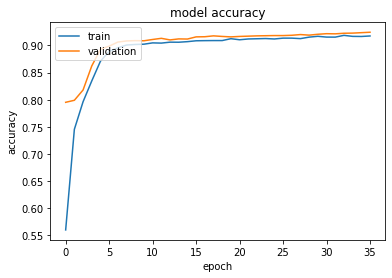

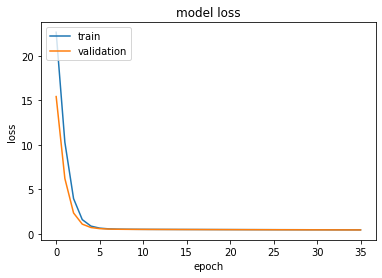

In [22]:
# plot history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

In [23]:
# testing the model
y_hat = model.predict(X_test)

In [24]:
# testing accuracy
print("Testing Accuracy")
accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat)))

Testing Accuracy


0.925

In [25]:
# Confusion matrix (testing)
confusion_matrix(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat)))

array([[973,  74],
       [ 82, 951]])